*This code is written by Yassine Ghouzam. (https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)

- 1. Introduction
- 2. Load and check data
    - 2.1 load data
    - 2.2 Outlier detection
    - 2.3 joining train and test set
    - 2.4 check for null and missing values
- 3 Feature analysis
    - 3.1 Numerical values
    - 3.2 Categorical values
- 4 Filling missing Values
    - 4.1 Age
- 5 Feature engineering
    - 5.1 Name/Title
    - 5.2 Family Size
    - 5.3 Cabin
    - 5.4 Ticket
- 6 Modeling
    - 6.1 Simple modeling
        - 6.1.1 Cross validate models
        - 6.1.2 Hyperparamater tunning for best models
        - 6.1.3 Plot learning curves
        - 6.1.4 Feature importance of the tree based classifiers
    - 6.2 Ensemble modeling
        -6.2.1 Combining models
    - 6.3 Prediction
        - 6.3.1 Predict and Submit results

## 1. Introduction
본 커널은 Feature Engineering과 Ensemble modeling을 소개하기 위해 Yassine Ghouzam가 공개한 커널입니다. 몇 가지 Feature Analysis를 수행한 후 Feature Engineering을 거쳐 데이터에 대한 모델링 작업을 하고 타이타닉 승선자 중 생존자를 투표 방식으로 예측해볼 것입니다. 

이 스크립트는 아래의 세 가지 메인 파트로 구성되어 있습니다: 
1. Feature Analysis
2. Feature Engineering
3. Modeling

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from collections import defaultdict
from collections import Counter # 컨테이너에 동일한 값의 자료가 몇개인지 파악하기 위해 사용되는 객체(https://excelsior-cjh.tistory.com/94)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')


## 2. Load and Check Data
### 2.1 Load Data

In [2]:
currentPath = os.getcwd() # 현재 노트북이 위치한 경로 확인
trainPath = os.path.join(currentPath, 'train.csv') # csv파일과 현재 경로를 join
testPath = os.path.join(currentPath, 'test.csv')

# .csv를 pandas dataframe으로 변환
train = pd.read_csv(trainPath)
test = pd.read_csv(testPath)

IDtest = test["PassengerId"] 
print(IDtest) # 승객 ID 출력

0       892
1       893
2       894
3       895
4       896
5       897
6       898
7       899
8       900
9       901
10      902
11      903
12      904
13      905
14      906
15      907
16      908
17      909
18      910
19      911
20      912
21      913
22      914
23      915
24      916
25      917
26      918
27      919
28      920
29      921
       ... 
388    1280
389    1281
390    1282
391    1283
392    1284
393    1285
394    1286
395    1287
396    1288
397    1289
398    1290
399    1291
400    1292
401    1293
402    1294
403    1295
404    1296
405    1297
406    1298
407    1299
408    1300
409    1301
410    1302
411    1303
412    1304
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64


## 2.2 Outlier Detection
여기에서는 NaN, Null과 같은 Outliers를 검출해 봅니다. 

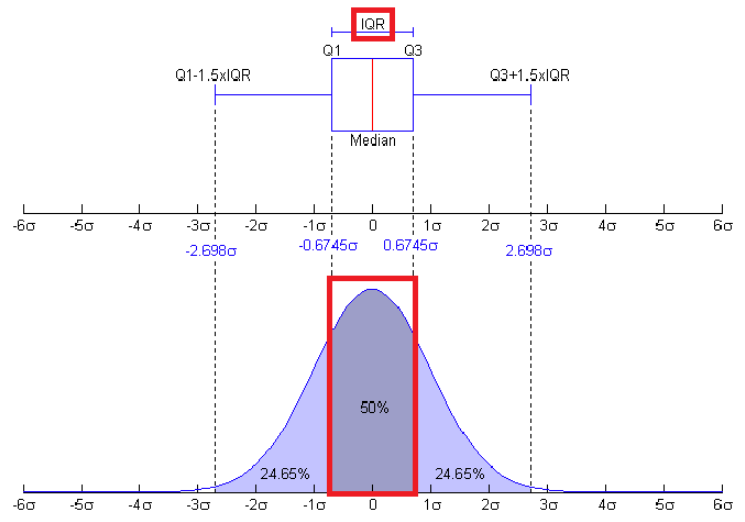
이미지 출처:https://blog.naver.com/PostView.nhn?blogId=sw4r&logNo=221021173204

In [3]:
# 이상치 검출

def detect_outliers(df,n,features):
    # features의 dataframe df를 받아 Turkey method에 따라 n개 이상의 outlier에 해당하는 인덱스 목록을 반환
    outlier_indices = []
    
    # features의 columns에 대해 이터레이션 수행
    for col in features:
        # 1st quartile (사분위수, 25%) - 데이터의 중앙값 아래에서의 중앙값을 의미
        Q1 = np.percentile(df[col], 25)

        # 3rd quartile (75%) - 데이터 중앙값 위에서의 중앙값을 의미
        Q3 = np.percentile(df[col],75)
        
        # Interquartile range (IQR) - 사분범위(IQR)는 중간 50% 데이터들이 흩어진 정도를 의미하며, Q3-Q1으로 구할 수 있다.
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # feature cols로부터 outliers에 해당하는 리스트의 인덱스 결정 (tf의 truncated_normal과 비슷하게 양 끝단을 자르는 것과 비슷한듯.)
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # 찾아낸 outlier 인덱스를 outlier indices cols에 추가
        outlier_indices.extend(outlier_list_col)
        
    # 2보다 큰 outlier를 포함하는 관측치를 선택
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# Age, SibSp, Parch, Fare cols에서 outliers를 검출
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

C:\Users\brsta\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Outliers는 특히 prediction(예측) 문제에 있어서 극적인 효과를 불러올 수 있기 때문에 이들을 관리해야 합니다. 

여기에서 우리는 Turkey method(Tukey JW., 1977)를 사용하여 분포값(IQR)의 1분위와 3분위 사이에 포함된 사분위수 범위(Interquartile range)를 정의하는 outliers를 탐지했습니다. Outliers는 (IQR - outlier_step) 범위의 밖에 존재하는 행(row)입니다. 

저는 features의 숫자형 값인 Age, SibSp, Sarch, Fare에서 Outliers를 검출하기로 결정했습니다. 그런 다음 Outliers는 적어도 두 개의 치명적인 값이 존재하는 행이라 여기기로 했습니다. 

In [4]:
train.loc[Outliers_to_drop] # Outliers에 해당하는 rows를 출력

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


이 결과로 우리는 10개의 outliers를 검출했습니다. 28, 88, 341번째 손님이 높은 티겟값을 지불했고, 7명 정도의 손님이 높은 SinSp값을 갖고 있는 것을 확인할 수 있습니다. 이제 이 Outliers를 버리도록 하겠습니다.

In [5]:
# 아웃라이어 버리기
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## 2.3 Joining and test set
Categorical로 변환하는 중 동일한 수의 feature를 얻기 위해 train과 test set을 결합(join)합니다. 

In [6]:
train_len = len(train) # 881
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

C:\Users\brsta\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## 2.4 Check for null and missing values
Null값과 Missing values를 확인 및 제거하는 과정을 진행해 봅니다. 이 값들은 학습 진행을 불가능하게 하므로 제어해야 합니다.

In [7]:
# 비어 있거나 NaNs인 값들을 NaN값으로 채웁니다. 
dataset = dataset.fillna(np.nan) # np.nan은 요소에 NaN을 대입하는 Numpy 함수

# Null값이 존재하는지 확인합니다. 
dataset.isnull().sum() # pd.isnull()은 누락되거나 NA인 값을 알려주는 불리언 값 객체를 반환합니다. 이를 요약한 결과(sum)를 반환합니다. 

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Age와 Cabin값은 missing values중 중요한 부분을 차지하고 있습니다. 

(?) Survived missing values correspond to the join testing dataset. 
살아남은 열은 test set에 존재하지 않으며, train과 test set을 연결(concatenate)할때 NaN값으로 대체되었습니다.

In [8]:
# train set의 정보를 출력해 보기
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
# 데이터 요약해보기(요약 및 통계)
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature Analysis
## 3.1. Numerical values
여기에서는 Survived를 기준으로 하여 숫자형 값들의 상관 행렬(Correlation Matrix)을 만들어 보겠습니다. 

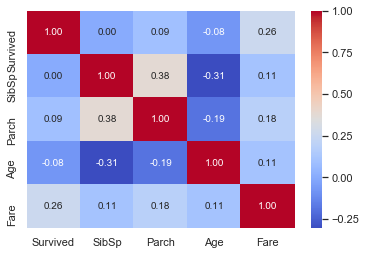

In [12]:
g = sns.heatmap(train[['Survived', 'SibSp','Parch','Age','Fare']].corr(), annot = True, fmt=".2f", cmap="coolwarm")

단지 Fare feature만이 생존 확률과 유의미한 상관 관계가 있는 것으로 보입니다. 그러나 다른 features가 유용하지 않다는 의미는 아닙니다. 이러한 features의 하위 집단은 생존 여부와 상관이 있을 수 있습니다. 이를 확인하려면 다른 features를 자세히 조사할 필요가 있습니다. 

#### - SibSp Feature에 대해 분석해보기

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\brsta\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


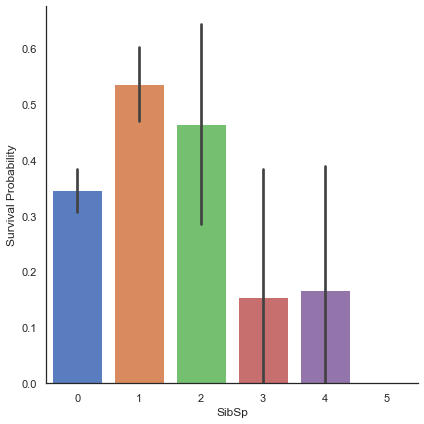

In [13]:
# SibSp feature과 Survived 사이의 관계를 탐색해 봅니다. 
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6, palette="muted")
g = g.set_ylabels("Survival Probability")

형제/배우자가 많은 승객은 생존 기회가 적습니다. 
단일 승객(SibSp 0)이나 두 명의 승객(SibSp 1 또는 2)은 더 많은 생존 기회가 있었습니다. 
이러한 관측은 꽤 흥미롭습니다. 이를 통해 우리는 이제 이 카테고리를 설명하기 위한 몇 개의 features를 고려할 수 있습니다. 

#### - Parch Feature에 대해 분석해보기

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


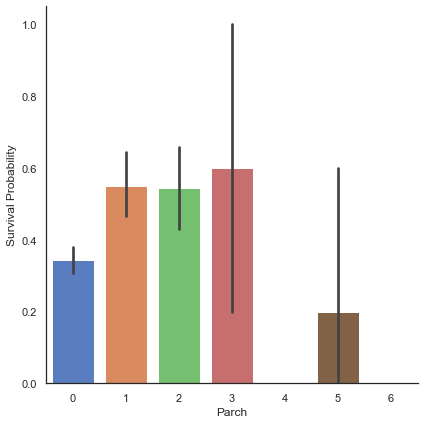

In [14]:
# Parch feature과 Survived 사이의 관계를 탐색해 봅니다. 
g = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette='muted')
g = g.set_ylabels("Survival Probability")

작은 가족들은 단일(Parch 0), 중간(Parch 3, 4), 큰(Parch 5, 6) 크기의 가족들에 비해 생존 기회가 더 많았습니다. 부모/자녀가 3명인 승객의 생존 여부에 중요한 표준 편차가 있음에 유의해야 합니다. 

#### - Age Feature에 대해 분석해보기

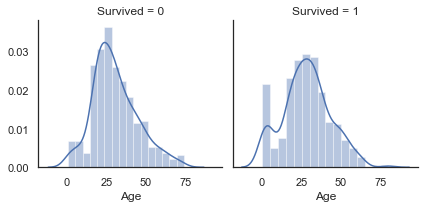

In [15]:
# Age feature과 Survived 사이의 관계를 탐색해 봅니다. 
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

연령(Age)에 대한 분포는 꼬리 분포(Tailed distribution, 왼쪽 또는 오른쪽으로 최빈값이 몰려 있고 다른 방향으로 갈수록 꼬리가 길어지는 형태의 분포) 또는 정규분포(Gaussian distribution)인 것처럼 보입니다. 

우리는 생존자 하위 집단과 사망자 하위 집단에서 연령 분포가 동일하게 나타나지 않는다는 것을 알 수 있습니다. 실제로, 젊은 승객에 해당하는 부분에 뾰족한 부분(peak)이 존재하는 것을 알 수 있습니다. 또한 60~80세 사이의 승객이 살아남지 못했음을 알 수 있습니다. 

따라서 Age feature가 생존 여부(Survived)와 상관 관계가 없더라도 생존 기회가 더 많거나 적은 승객의 연령 카테고리가 있음을 알 수 있습니다. 

표를 통해 아주 어린 나이의 승객들의 생존 기회가 더 많았음을 유추해 볼 수 있습니다. 

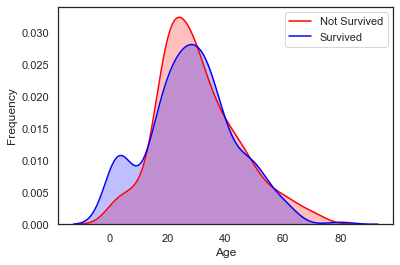

In [16]:
# Age 분포 탐색해 보기
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)

g.set_xlabel('Age')
g.set_ylabel('Frequency')

g = g.legend(['Not Survived', 'Survived'])

두 밀도를 겹쳐서 보게 되면, 우리는 0~5살 사이의 아기들 영역에서 튀는 값(peak)이 존재하는 것을 명확하게 확인할 수 있습니다. 

#### - Fare Feature에 대해 분석해보기

In [17]:
dataset['Fare'].isnull().sum() # NULL값이 존재하는지 확인해 봅니다. 

1

In [18]:
# missing value를 median value로 채웁니다. 
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

Fare feature에 한 개의 missing value가 존재하기 때문에, 예측에 중요한 영향을 미치지 않을 median value(중간값)로 채웁니다. 

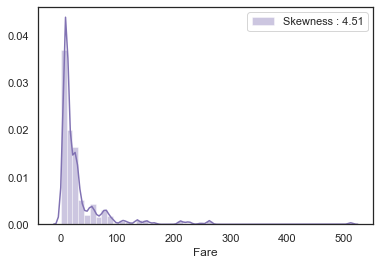

In [19]:
# Fare 분포 탐색해 보기
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

여기서 볼 수 있듯이, Fare의 분포는 매우 기울어 있습니다. 이러한 feature는 scale이 조정된 경우에도 모델에서 매우 높은 값으로 인한 초과(overweight very high values in the model)를 유발할 수 있습니다. 이 경우, 기울기를 줄이기 위해 로그 함수로 변환하는 것이 좋습니다. 

In [20]:
# 분포에 존재하는 기울기를 줄이기 위해 로그를 취해 줍니다. 
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

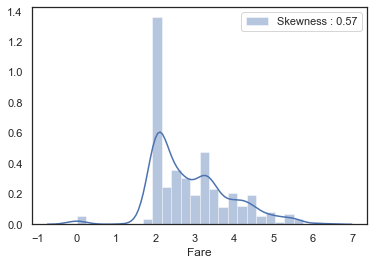

In [21]:
# 로그가 취해진 Fare 분포 탐색해 보기
g = sns.distplot(dataset['Fare'], color='b', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

로그 함수를 취해 주니 확실히 기울기가 줄어든 것이 보입니다. 

## 3.2. Categorical values

#### - Sex Feature에 대해 분석해보기

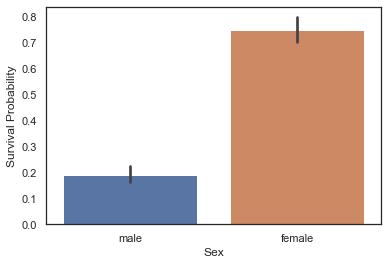

In [22]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [23]:
# train 내 Sex category에 따라 그룹을 묶고 평균을 출력합니다. 
train[['Sex', 'Survived']].groupby('Sex').mean() 

,Survived
Sex,
female,0.747573
male,0.190559


남성이 여성보다 생존 기회가 적었음이 분명합니다. 따라서 성별은 생존 예측에 중요한 역할을 할 수 있다는 것을 알 수 있습니다. 
1997년 개봉한 영화 타이타닉을 보신 분들이라면 배에서 탈출하는 장면에서의 대사인 "여자와 아이들 먼저"를 기억할 것입니다. 

#### - Pclass Feature에 대해 분석해보기

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


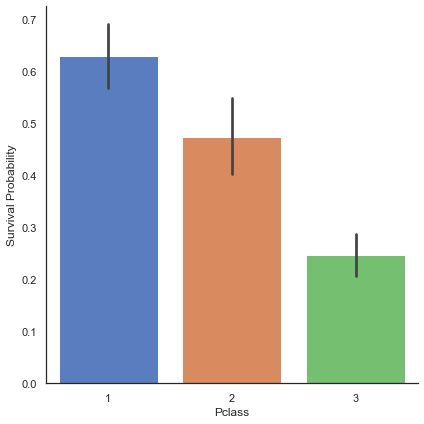

In [24]:
# Pclass feature과 Survived 사이의 관계를 탐색해 봅니다. 
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g = g.set_ylabels("Survival Probability")

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


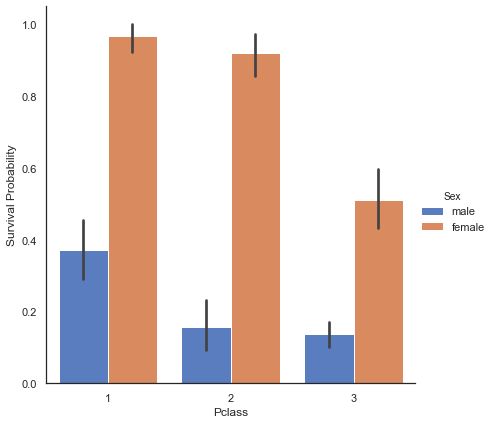

In [25]:
# Pclass feature과 성별에 따른 Survived 사이의 관계를 탐색해 봅니다. 
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g = g.set_ylabels('Survival Probability')

승객들의 생존 여부는 세 클래스 모두 동일하지 않음을 알 수 있습니다. 1등석 승객은 2등석, 3등석 승객보다 생존 기회가 더 많았습니다. 
이 추세는 남녀 승객 모두에 대해서 모두 나타남을 알 수 있습니다. 

#### - Embarked Feature에 대해 분석해보기

In [26]:
dataset['Embarked'].isnull().sum() # NULL값 찾기

2

In [27]:
dataset['Embarked']

0       S
1       C
2       S
3       S
4       S
5       Q
6       S
7       S
8       S
9       C
10      S
11      S
12      S
13      S
14      S
15      S
16      Q
17      S
18      S
19      C
20      S
21      S
22      Q
23      S
24      S
25      S
26      C
27      Q
28      S
29      C
       ..
1269    Q
1270    S
1271    S
1272    S
1273    S
1274    S
1275    S
1276    S
1277    Q
1278    C
1279    S
1280    Q
1281    S
1282    S
1283    C
1284    S
1285    C
1286    C
1287    S
1288    C
1289    Q
1290    S
1291    Q
1292    Q
1293    S
1294    S
1295    C
1296    S
1297    S
1298    C
Name: Embarked, Length: 1299, dtype: object

In [28]:
# Embarked feature에 존재하는 NaN값들을 데이터셋 내에서 가장 빈도가 높은 값인 'S'로 채웁니다. 
dataset['Embarked'] = dataset['Embarked'].fillna('S')

두 개의 누락된 값을 찾아내고 'S'값으로 채웠습니다. 

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


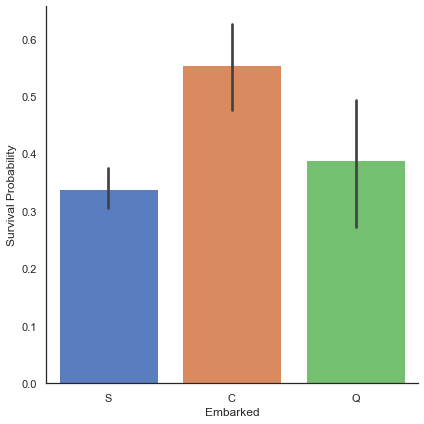

In [29]:
# Embarked feature과 Survived 사이의 관계를 탐색해 봅니다.
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g = g.set_ylabels('Survival Probability')

Cherbourg(C)에서 오는 승객들에게는 더 많은 생존 기회가 있었던 것으로 보입니다. 
저의 가설(Hypothesis)은 Cherbourg(C)에서 온 1등석 승객의 비율이 Queenstown(Q)과 Southampton(S)에서 온 1등석 승객 비율보다 높다는 것입니다. 
Pclass의 분포와 Embarked의 분포를 비교해 보겠습니다. 

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


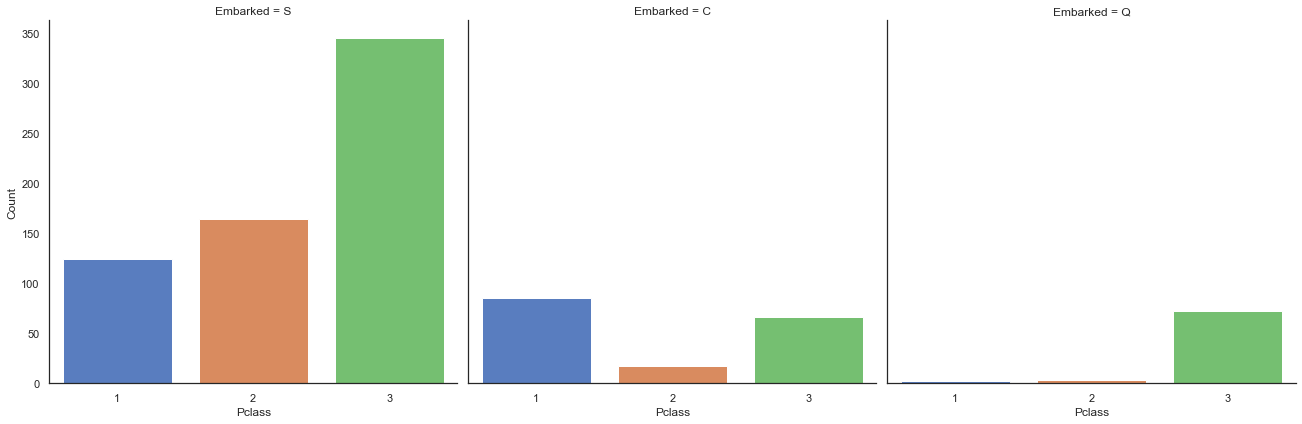

In [30]:
# Pclass와 Embarkes를 비교 분석해보기
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g = g.set_ylabels('Count')

삼등석 클래스는 Southampton(S)과 Queenstown(Q)에서 온 승객들이 가장 많은 반면 Cherbourg에서 온 승객들은 대부분 일등석이었으며, 생존률이 가장 높았습니다. 

이 부분에서 저는 왜 일등석이 높은 생존률을 보이는지 설명할 수 없었습니다. 제 생각에는 일등석이 아마 그들이 가진 영향력 때문에 대피에서 우선 순위가 부여되었던 것 같습니다. 

# 4. Finding missing Values
## 4.1 Age
전에 보았던 것처럼, 전체 데이터셋 중 Age 열은 256개의 missing values를 갖고 있습니다. 

생존 기회가 더 많은 하위 집단(ex. 어린이)이 있기 때문에 Age feature를 유지하며 누락된 값을 대체하는 것이 바람직합니다. 

이 문제를 해결하기 위해, Age와 가장 관련성이 높은 features(Sex, Parch, Pclass, SibSp)를 살펴 보겠습니다.

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.wa

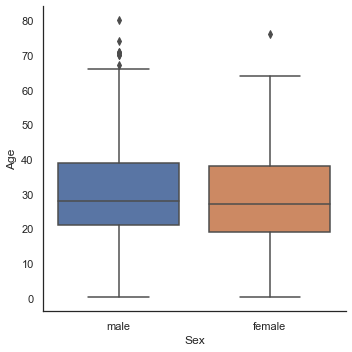

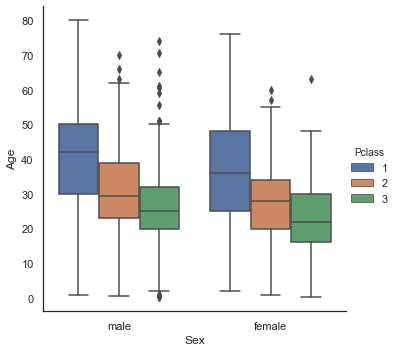

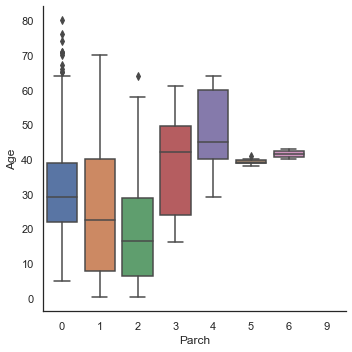

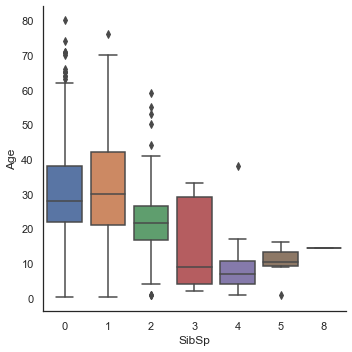

In [31]:
# Age와 Sex, Parch, Pclass, SibSp 간의 관계 살펴보기
g = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

Age 분포는 남성 및 여성의 하위 인구 집단에서 동일하기 때문에 Sex는 Age를 예측하는데 유익하지 않습니다. 그러나 1등석 승객은 2등석 승객보다 나이가 많고, 2등석 승객은 3등석 승객보다 나이가 많습니다. 또한 부모/자녀가 많은 남자 승객일수록 나이가 많으며 형제/배우자가 있는 남자 승객일수록 젊었습니다. 

In [32]:
# Sex를 0은 남자, 1은 여성 카테고리를 갖는 categorical value로 변환합니다. 
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

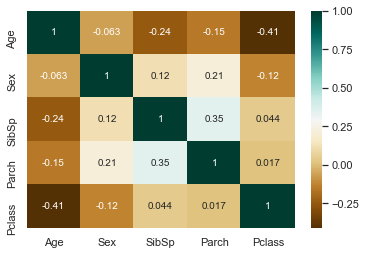

In [33]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

상관 관계 맵(correlation map)은 Parch를 제외한 factorplots를 보여줍니다. Age는 Sex와 상관이 없지만 Pclass, Parch 및 SibSp와 음의 상관 관계가 있습니다. 

(역자 주 : 상관관계란 어떤 변수가 증가할 때 다른 변수가 함께 증가하는지 감소하는지를 관찰해 그 관계를 파악하기 위한 것으로, 체중과 신장 사이에는 양의 상관관계가, 수요와 가격의 사이에는 음의 상관관계가 있다고 할 수 있다. 이는 가격이 오르면 대개 해당 상품에 대한 수요가 줄어들기 때문이다. 더 자세한 설명은 https://kiyoo.tistory.com/210 참고.)

Age에 대한 도표에서 Parch의 기능을 보면, Age는 부모/아이들의 수에 따라 증가하는 것을 확인할 수 있습니다. 그러나 일반적으로 상관 관계는 음(negetive)입니다. 

그래서 저는 SibSp, Parch, Pclass를 사용하여 누락된 Age를 설명하기로 결정했습니다. 바로 Pclass, Parch, SibSp에 따라 Age를 비슷한 행의 평균 연령으로 채우는 것입니다. 

In [34]:
# 누락된 Age값 채우기 - 빈 Age를 Pclass, Parch, SibSp에 따라 비슷한 행의 중간값(median age)으로 채웁니다. 

# NaN값을 갖는 Age 행들의 인덱스 리스트
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) &
                               (dataset['Parch'] == dataset.iloc[i]['Parch']) & 
                               (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med
    

C:\Users\brsta\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(역자 주 : loc과 iloc은 행 및 열을 추출할 때 대표적으로 쓰이는 함수로, loc은 컬럼명과 같이 이름을 기준으로 할 때 많이 쓰이는 반면 iloc은 index 기준, 즉 숫자를 이용하므로 특정 규칙에 따라 추출할 수 있습니다.)

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diff

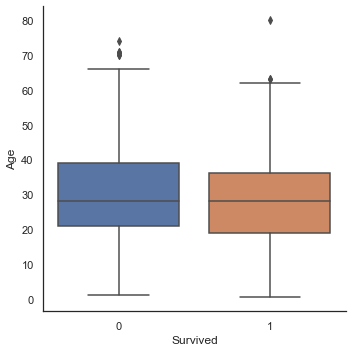

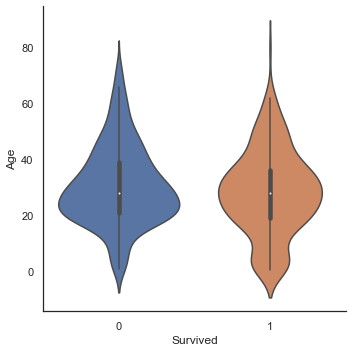

In [35]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

Age에 따른 생존한 하위집단과 사망한 하위집단 사이의 중간값 차이는 존재하지 않습니다. 그러나 생존한 승객들의 바이올린 그래프에서 우리는 여전히 어린 아이들이 높은 생존율을 보이는 것을 확인할 수 있습니다. 

# 5. Feature Engineering
## 5.1 Name/Title

In [36]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name feature는 승객 칭호에 대한 정보를 담고 있습니다. 기품 있는 칭호를 가진 승객이 탈출 과정에서 선호될 수 있기 때문에 Name feature를 모델에 추가하는 것은 꽤 흥미롭습니다. 

In [37]:
# Name으로부터 칭호 가져오기
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset['Title'] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

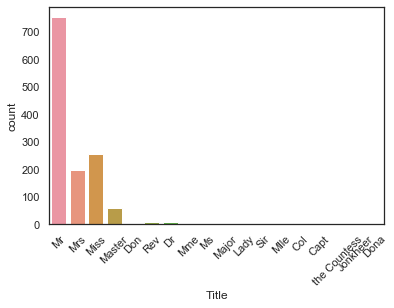

In [38]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

dataset에는 17개의 호칭이 존재합니다. 대부분의 칭호가 매우 드물기 때문에 우리는 4개 정도의 카테고리로 나머지 칭호들을 그룹화할 수 있습니다.

In [39]:
# 범주형 값으로 Title feature를 변환합니다
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset['Title'] = dataset['Title'].astype(int)

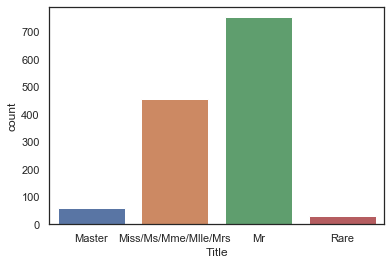

In [40]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs','Mr', 'Rare'])

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


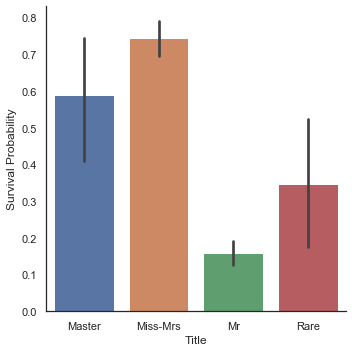

In [41]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind = 'bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival Probability')

"여성과 어린 아이를 먼저 탈출시켜라"

희귀한 칭호를 가진 승객은 생존 기회가 더 많은 것을 알 수 있습니다. 

In [42]:
# Name variable Drop하기
dataset.drop(labels=['Name'], axis=1, inplace=True)

## 5.2 Family size
우리는 여기서 대가족일수록 탈출이 어렵다는 것을 상상해볼 수 있습니다. 탈출하는 동안 자매/형제/부모를 찾아야 하기 때문입니다. 그래서 저는 SibSp, Parch and 1(승객 포함)을 합친 'Fize'(가족 크기)라는 feature를 만들기로 했습니다. 

In [43]:
# SibSp와 Parch feature를 이용해 가족 크기에 대해 설명하는 feature를 만듭니다. 
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


ValueError: Invalid RGBA argument: masked

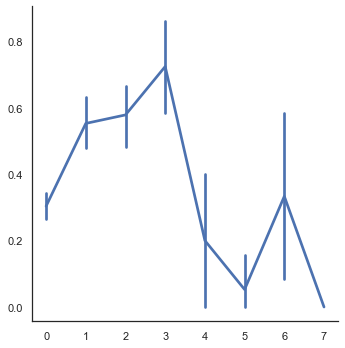

In [44]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

가족 크기(Fsize) feature는 중요한 역할을 맡고 있는 것처럼 보입니다. 생존율은 대가족에서 매우 심각했습니다. 여기에 이어서, 저는 가족 크기에 대해 4개의 카테고리를 만들기로 했습니다. 

In [45]:
# 가족 크기에 대한 새로운 feature를 만듭니다. 
dataset['Single'] = dataset['Fsize'].map(lambda s:1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s:1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s:1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s:1 if s >= 5 else 0)

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.wa

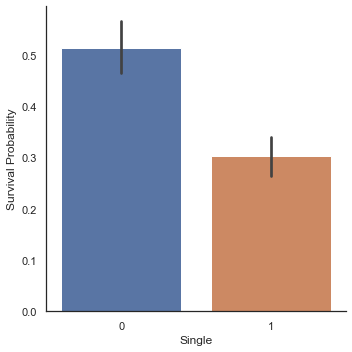

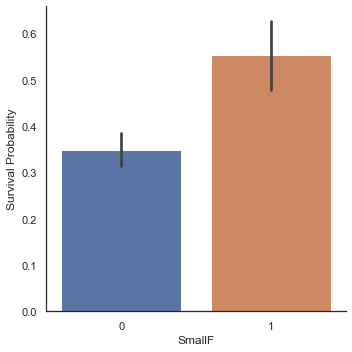

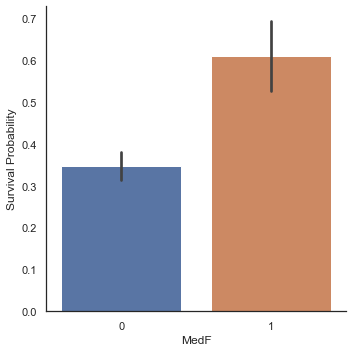

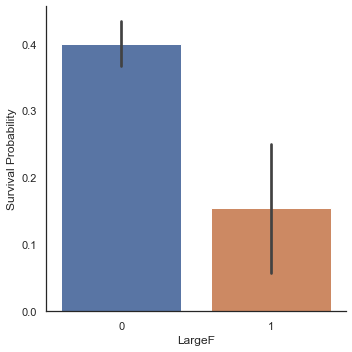

In [46]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

가족 크기에 따른 Factorplot들은 작거나 중간 크기의 가족들이 혼자 탑승한 승객이나 대가족보다 생존 기회가 더 많았음을 보여줍니다. 

In [47]:
# 지시자(Indicator values)를 Title과 Embarked로 변환합니다. 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [48]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


이 시점에서, 우리는 22개의 features를 갖게 됩니다.

## 5.3 Cabin

In [49]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [50]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [51]:
dataset['Cabin'].isnull().sum()

1007

Cabin feature 열은 292개의 값과 1007개의 누락값을 갖고 있습니다. 저는 Cabin(객실)이 없는 승객은 Cabin number를 갖고 있지 않기 때문에 객실 번호 대신 누락된 값을 갖고 있다고 생각합니다. 

In [52]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [53]:
# 만일 객실이 없는 승객이라면 객실 번호(Cabin Number)를 'X'로 바꿉니다. 
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

객실 번호의 첫 번째 문자는 갑판을 가리키며, 이는 타이타닉 호에서 승객이 있을 만한 위치를 가리키기 때문에 이 정보만 유지하도록 하겠습니다. 

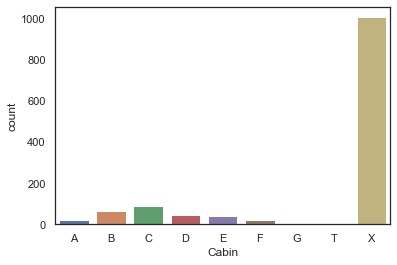

In [54]:
g = sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

C:\Users\brsta\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


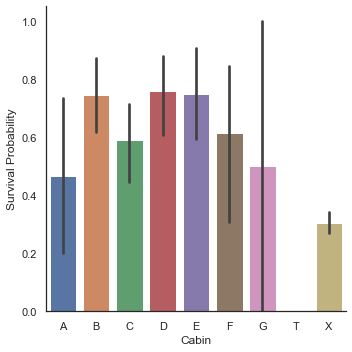

In [55]:
g = sns.factorplot(y='Survived', x='Cabin', data=dataset, kind = 'bar', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Probability')

객실을 가진 승객의 수가 적기 때문에 생존 확률은 중요한 표준편차를 가지며, 따라서 우리는 각각 다른 갑판에서의 승객 생존 확률을 구분할 수 없습니다. 
그러나 객실이 있던 승객은 객실이 없던 승객보다 생존 기회가 더 많았음을 알 수 있습니다. 객실 B, C, D, E, F의 경우는 특히 더 그렇습니다. 

In [56]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

## 5.4 Ticket

In [57]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

같은 접두사를 공유하는 티켓의 객실은 같이 배치되어 있다고 볼 수 있습니다. 따라서 실제 객실의 배치를 유추해 볼 수 있습니다.
같은 접두사를 가진 티켓은 비슷한 객실 등급과 생존율을 가질 수 있습니다. 
따라서 저는 Ticket feature 열을 티겟 접두사로 대체하기로 했습니다. 이게 더 유익할 수 있기 때문입니다. 

In [58]:
# 티켓의 접두사를 추출해 티켓을 처리합니다. 접두사가 없으면 'X'를 반환합니다. 
 
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0]) # Take Prefix
    else:
        Ticket.append('X')
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [59]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [60]:
# Pclass를 위한 범주형 자료(Categorical values)를 만듭니다. 
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [61]:
# 필요없는 값들을 Drop합니다. 
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [62]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6. Modeling

In [63]:
# Train set과 Test set을 분리합니다. 
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis=1, inplace=True)

C:\Users\brsta\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [64]:
# train features와 labels를 분리합니다. 
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=["Survived"], axis=1)

C:\Users\brsta\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 6.1 Simple Modeling
### 6.1.1 Cross Validate Models
저는 10개의 인기있는 분류기를 비교하고 계층화된 K-Fold validation 절차를 통해 각자의 평균 정확도를 평가하기로 했습니다. 
- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple Layer Perceptron (Neural Network)
- KNN
- Logistic Regression
- Linear Discriminant Analysis


In [65]:
# 계층화된 K-Fold Cross Validation model
kfold = StratifiedKFold(n_splits=10)

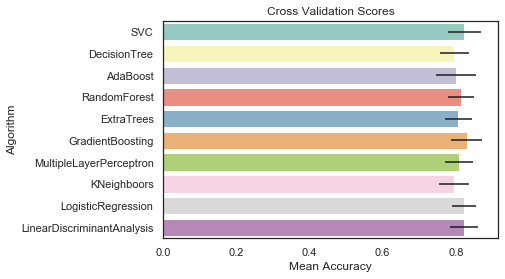

In [71]:
# 다양한 알고리즘들을 통해 모델링 단계 테스트하기
random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerrors':cv_std, 
                       'Algorithm':['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 
                                    'MultipleLayerPerceptron', 'KNeighboors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

# xerr 인수나 yerr 인수를 지정하면 에러 바(error bar)를 추가할 수 있다.
g = sns.barplot('CrossValMeans','Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')

저는 앙상블 모델링을 위해 SVC, RandomForest, ExtraTrees 및 GradientBoosting 분류기를 선택하기로 했습니다. 

### 6.1.2 Hyperparameter tunning for best models
저는 AdaBoost, ExtraTrees, RandomForest, GradientBoosting 및 SVC 분류기에 대한 Grid search 최적화를 수행했습니다. 저는 4개의 CPU를 갖고 있기 때문에 'n_jobs'의 매개 변수를 4로 설정했습니다. 계산 시간이 확실히 줄어듭니다. 

이 단계는 오랜 시간이 걸릴 수 있으므로 유의해야 합니다. 저는 4개의 CPU에서 15분 정도의 시간이 소요되었습니다.